# CNN to Classify Dog Breeds

## Import Dataset

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [298]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

humans_detected = 0
for human_file in human_files_short:
    if dog_detector(human_file):
        humans_detected = humans_detected + 1
        
dogs_detected = 0
for dog_file in dog_files_short:
    if dog_detector(dog_file):
        dogs_detected = dogs_detected + 1

print(str(humans_detected) + "% of dogs detected in humans!")
print(str(dogs_detected) + "% of dogs detected in dogs!")

1% of dogs detected in humans!
100% of dogs detected in dogs!


## Pre-process the Data

Rescale the images by dividing every pixel in every image by 255.

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

## Pre-process the Data

Rescale the images by dividing every pixel in every image by 255.

100%|██████████| 836/836 [00:04<00:00, 189.32it/s]


## CNN using Transfer Learning

Using the bottleneck features from - [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) 

In [9]:
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train = bottleneck_features['train']
valid = bottleneck_features['valid']
test = bottleneck_features['test']

## Model

In [10]:
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train.shape[1:]))
model.add(Dense(500, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               66633     
Total params: 1,091,133.0
Trainable params: 1,091,133.0
Non-trainable params: 0.0
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Training

In [22]:
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.xception import Xception, preprocess_input

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('dogImages/train',
                                                  target_size=(224,224),
                                                 batch_size= 20,
                                                  class_mode='categorical')

validation_generator = test_datagen.flow_from_directory('dogImages/valid',
                                                       target_size=(224,224),
                                                       batch_size= 20,
                                                       class_mode='categorical')

Xmodel = Xception(weights='imagenet', include_top=False)

train = Xmodel.predict_generator(train_generator, 6680, verbose=1)

valid = Xmodel.predict_generator(validation_generator, 835, verbose=1)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.model.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train, train_targets, 
          validation_data=(valid, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 6s - loss: 0.0075 - acc: 0.9984 - val_loss: 1.0954 - val_acc: 0.8467
Epoch 2/20
6680/6680 [==============================] - 6s - loss: 0.0091 - acc: 0.9982 - val_loss: 1.0841 - val_acc: 0.8479
Epoch 3/20
6680/6680 [==============================] - 6s - loss: 0.0131 - acc: 0.9978 - val_loss: 1.0764 - val_acc: 0.8431
Epoch 4/20
6680/6680 [==============================] - 6s - loss: 0.0105 - acc: 0.9982 - val_loss: 1.1012 - val_acc: 0.8515
Epoch 5/20
6680/6680 [==============================] - 6s - loss: 0.0103 - acc: 0.9978 - val_loss: 1.1408 - val_acc: 0.8479
Epoch 6/20
6680/6680 [==============================] - 6s - loss: 0.0098 - acc: 0.9985 - val_loss: 1.1380 - val_acc: 0.8383
Epoch 7/20
6680/6680 [==============================] - 6s - loss: 0.0070 - acc: 0.9979 - val_loss: 1.0450 - val_acc: 0.8443
Epoch 8/20
6680/6680 [==============================] - 6s - loss: 0.0125 - ac

In [23]:
model.load_weights('saved_models/weights.best.model.hdf5')

### Testing
 model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [24]:
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.9282%


### Predict Dog Breed 

In [32]:
from extract_bottleneck_features import *
import cv2
import matplotlib.pyplot as plt

def dog_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

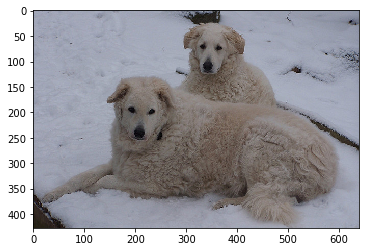

That's a dog of breed - Kuvasz


In [35]:
def dog_breed_detector(img_path):
    breed = dog_breed(img_path) 
    
    # Display the image
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    print("That's a dog of breed - " + str(breed))
    
dog_breed_detector(train_files[0])